In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.special import gamma
import utils as ut
import fBm_stats as fbms
import matplotlib.pyplot as plt
plt.style.use("plot_style.mplstyle")


data_path = "../data/fbm/"
h_s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Comparison between fBm algorithms 

100%|██████████| 10/10 [00:00<00:00, 1864.14it/s]


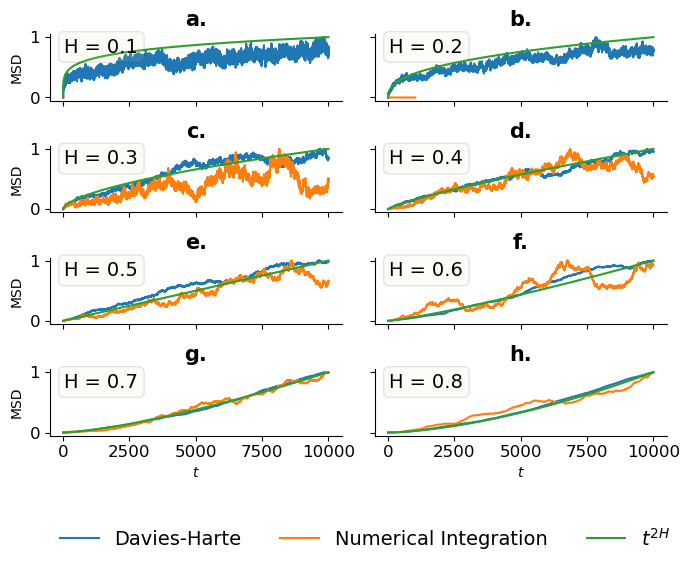

In [2]:
fig, ax = plt.subplots(int(len(h_s)/2), 2, sharex = True, sharey = True, figsize = (7,5))
col = 0
row = 0
panels = ["a.", "b.", "c.", "d.", "e.", "f.", "g.", "h."]
for i, h in enumerate(h_s):
    df_dh = ut.read_hdf5_data(data_path + f"fBm_dh-h-{h}-100.hdf5").set_index("t")
    df_in = ut.read_hdf5_all(h, data_path, 1, 10).set_index("t")
    msd_dh = fbms.msd(df_dh)
    msd_in = fbms.msd(df_in)
    
    t = df_in.index
    msd_anal = t**(2*h)
    msd_anal = msd_anal/max(msd_anal)
    
    axi = ax[row][col]

    axi.plot(t,msd_dh, label = "Davies-Harte")
    axi.plot(t,msd_in, label = "Numerical Integration")
    axi.plot(t,msd_anal, label = r"$t^{2H}$")
    axi.set_title(panels[i])
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
    axi.text(0.05, 0.95, f"H = {h}", transform=axi.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    if row == len(h_s)/2 - 1: axi.set_xlabel("$t$")

    if col == 1: row += 1; col = 0
    else: col += 1; axi.set_ylabel("MSD")


fig.tight_layout()
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (0.99, -0.03), ncol = len(h_s)/2);


# Normalization constant of the algorithms

From the definition of Brownian motion we have


$$cov(B_H(t), B_H(s)) = \frac{\sigma_0^2\Gamma(2-2H)}{4H\Gamma(\frac{3}{2}-H)\Gamma(\frac{1}{2}+H)}(t^{2H}+s^{2H}-|t-s|^{2H})$$ 

$$E[B_H^2(t)] = \frac{\sigma_0^2\Gamma(2-2H)}{2H\Gamma(\frac{3}{2}-H)\Gamma(\frac{1}{2}+H)}t^{2H}$$ 



In [3]:
def zeta(H):
    return gamma(2 - 2*H) /(4 * H * gamma(1.5 - H) * gamma(0.5 + H))

/tmp/ipykernel_400615/3503147169.py:2: RuntimeWarning: divide by zero encountered in divide
  return gamma(2 - 2*H) /(4 * H * gamma(1.5 - H) * gamma(0.5 + H))


Text(0.5, 0, 'H')

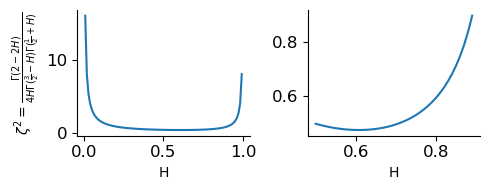

In [4]:
H = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(1,2, figsize = (5, 2))
ax[0].plot(H, zeta(H))
ax[0].set_xlabel(r"H")
ax[0].set_ylabel(r"$\zeta^2 = \frac{\Gamma(2-2H)}{4H\Gamma(\frac{3}{2}-H)\Gamma(\frac{1}{2}+H)}$");

H = np.arange(0.5, 0.9, 0.01)
ax[1].plot(H, zeta(H))
ax[1].set_xlabel(r"H")

## Normalization constant

* The fBm library implemented in python returns normalized trajectories to fit:
$$E[B_H^2(t)] = t^{2H}$$ 

and 

$$cov(B_H(t), B_H(s)) = \frac{1}{2}(t^{2H}+s^{2H}-|t-s|^{2H})$$

In [5]:
from fbm import FBM
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [6]:
def get_fBm(H, T, n):
    f = FBM(n = n, hurst = H, length = T, method = "daviesharte")
    B_H = f.fbm()
    dB_H = n/T*np.diff(B_H)   
    t_BH = f.times()
    t = t_BH[:n]
    return t, t_BH, B_H, dB_H

# Mean Squared Displacement

In [7]:
def plot_msd_fBm(ax, H, dt = 0.1, T = 10, realizations = 6000):
    
    n = int(T/dt)
    
    for r in tqdm(range(realizations)):
        t, t_BH, B_H, dB_H = get_fBm(H, T,n)
        if r == 0:
            fbm_series = pd.DataFrame({"t": t_BH})
        fbm_series["BH_"+str(r)] = B_H
    fbm_series.set_index("t", inplace = True)
    mean = fbm_series.mean(axis = 1)
    msd = (fbm_series**2).mean(axis = 1)
    
    t = np.array(msd.index)
    msd_anl = t**(2*H)

    ax.plot(t, msd, label = "Sim.")
    ax.plot(t, msd_anl, label = "Anl.", ls = "--")
    ax.set_xlabel("t")
    ax.set_ylabel("MSD")
    
    ax.set_title("H = " + str(H))

100%|██████████| 6000/6000 [00:20<00:00, 299.38it/s]


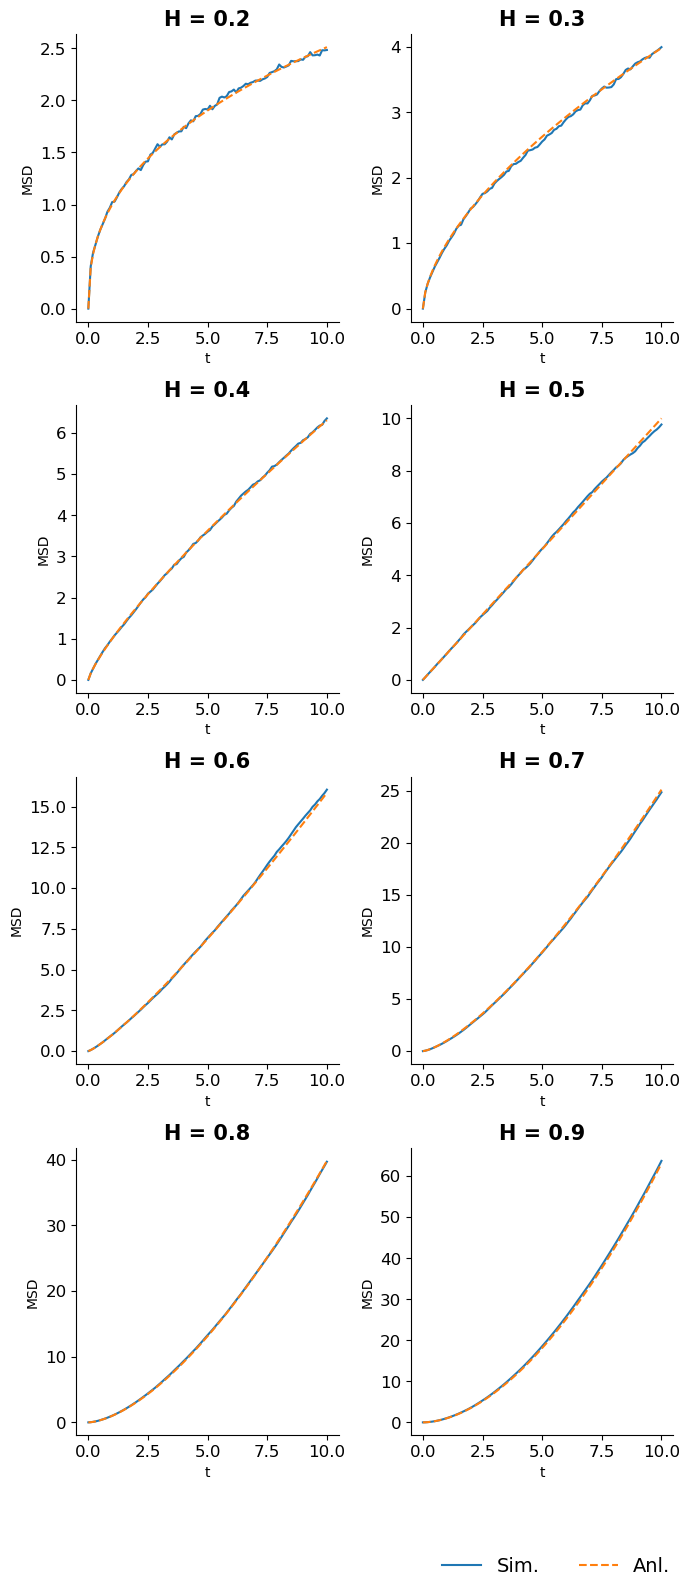

In [8]:
t_ref = 5
fig, ax = plt.subplots(4, 2, figsize=(7,15))


H = 0.2
plot_msd_fBm(ax[0][0], H)

H = 0.3
plot_msd_fBm(ax[0][1], H)

H = 0.4
plot_msd_fBm(ax[1][0], H)

H = 0.5
plot_msd_fBm(ax[1][1], H)

H = 0.6
plot_msd_fBm(ax[2][0], H)

H = 0.7
plot_msd_fBm(ax[2][1], H)

H = 0.8
plot_msd_fBm(ax[3][0], H)

H = 0.9
plot_msd_fBm(ax[3][1], H)

fig.tight_layout()
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (0.99, -0.03), ncol = len(h_s)/2);

# (AUTO)COVARIANCE

In [9]:
def cov_fBm(t, t_ref, H):
    return 0.5*(t**(2*H) + t_ref**(2*H) - np.abs(t-t_ref)**(2*H))

In [10]:
def plot_cov_fBm(ax, H, t_ref, dt = 0.1, T = 10, realizations = 20000):
    n = int(T/dt)
    
    for r in tqdm(range(realizations)):
        t, t_BH, B_H, dB_H = get_fBm(H, T, n)
        if r == 0:
            fbm_series = pd.DataFrame({"t": t_BH})
        fbm_series["BH_"+str(r)] = B_H
                
    fbm_series.set_index("t", inplace = True)
    autocov = fbms.cov(fbm_series, t_ref)
    t = autocov.index
    autocov = np.where((autocov > autocov.quantile(0.99)) | (autocov < autocov.quantile(0.001)), np.nan, autocov)
    ax.plot(t_BH, autocov, label = "Autocov num.")
    ax.plot(t_BH, cov_fBm(t, t_ref, H), label = "Autocov anl." , ls = "--")
    ax.set_xlabel("t")
    ax.set_ylabel("Autocov")
    ax.set_title(f"H = {H}")

100%|██████████| 20000/20000 [01:17<00:00, 258.89it/s]


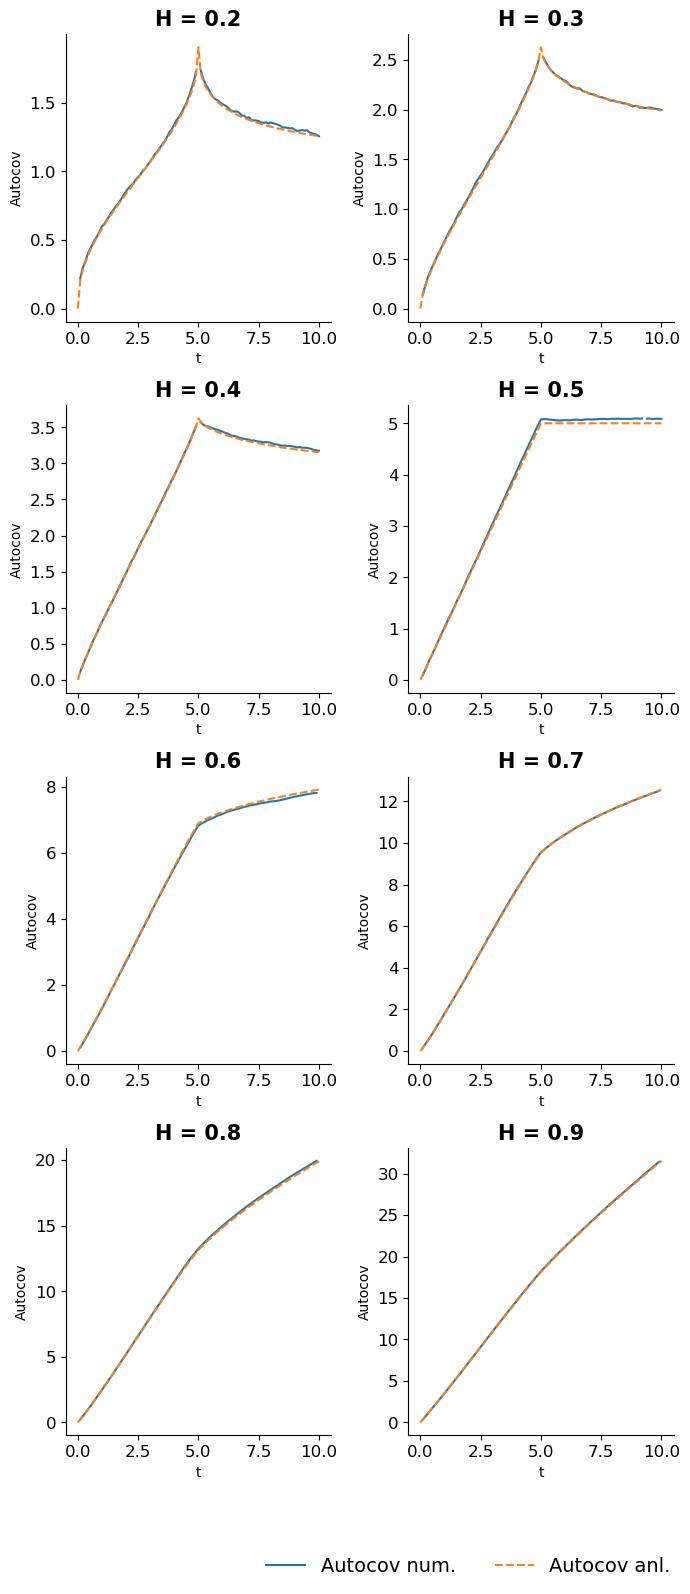

In [11]:
t_ref = 5
fig, ax = plt.subplots(4, 2, figsize=(7,15))


H = 0.2
plot_cov_fBm(ax[0][0], H, t_ref)

H = 0.3
plot_cov_fBm(ax[0][1], H, t_ref)

H = 0.4
plot_cov_fBm(ax[1][0], H, t_ref)

H = 0.5
plot_cov_fBm(ax[1][1], H, t_ref)

H = 0.6
plot_cov_fBm(ax[2][0], H, t_ref)

H = 0.7
plot_cov_fBm(ax[2][1], H, t_ref)

H = 0.8
plot_cov_fBm(ax[3][0], H, t_ref)

H = 0.9
plot_cov_fBm(ax[3][1], H, t_ref)

fig.tight_layout()
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (0.99, -0.03), ncol = len(h_s)/2);


## fractional Gaussian Noise

Similarly, the covariance and expected value of the fGn $\xi_H = \frac{d B_H (t)}{dt}$ are given by:


$$\frac{\partial^2}{\partial t \partial s} cov(\xi_H(t), \xi_H(s)) = cov(\xi_H(t), \xi_H(s)) = \frac{\sigma_0^2(2H-1)\Gamma(2-2H)}{4\Gamma(\frac{3}{2}-H)\Gamma(\frac{1}{2}+H)}|t-s|^{2H-2}$$ 



NOTES:
* In the fBm algorithms $V = 1$ thus, the covariance must fit 

$$ cov(\xi_H(t), \xi_H(s)) = H(2H-1)|t-s|^{2H-2}$$ 

TODO: noise covariance and scaling factor

In [12]:
def cov_fGn(t, t_ref, H):
    return  H*(2*H-1)*(np.abs(t-t_ref)**(2*H-2))

In [17]:
def plot_cov_noise(ax, H, t_ref, dt = 0.1, T = 10, realizations = 20000):
    n = int(T/dt)
    
    for r in tqdm(range(realizations)):
        t, t_BH, B_H, dB_H = get_fBm(H, T, n)
        if r == 0:
            noise = pd.DataFrame({"t": t})
        noise["dBH_"+str(r)] = dB_H
                
    noise.set_index("t", inplace = True)
    autocov = fbms.cov(noise, t_ref)
    t = autocov.index
    autocov = np.where((autocov > autocov.quantile(0.99)) | (autocov < autocov.quantile(0.001)), np.nan, autocov)
    ax.plot(t, autocov, label = "Autocov num.")
    ax.plot(t, cov_fGn(t, t_ref, H), label = "Autocov anl.")
    ax.set_xlabel("t")
    ax.set_ylabel("Autocov")
    ax.set_title(f"H = {H}")


100%|██████████| 20000/20000 [01:15<00:00, 264.05it/s]


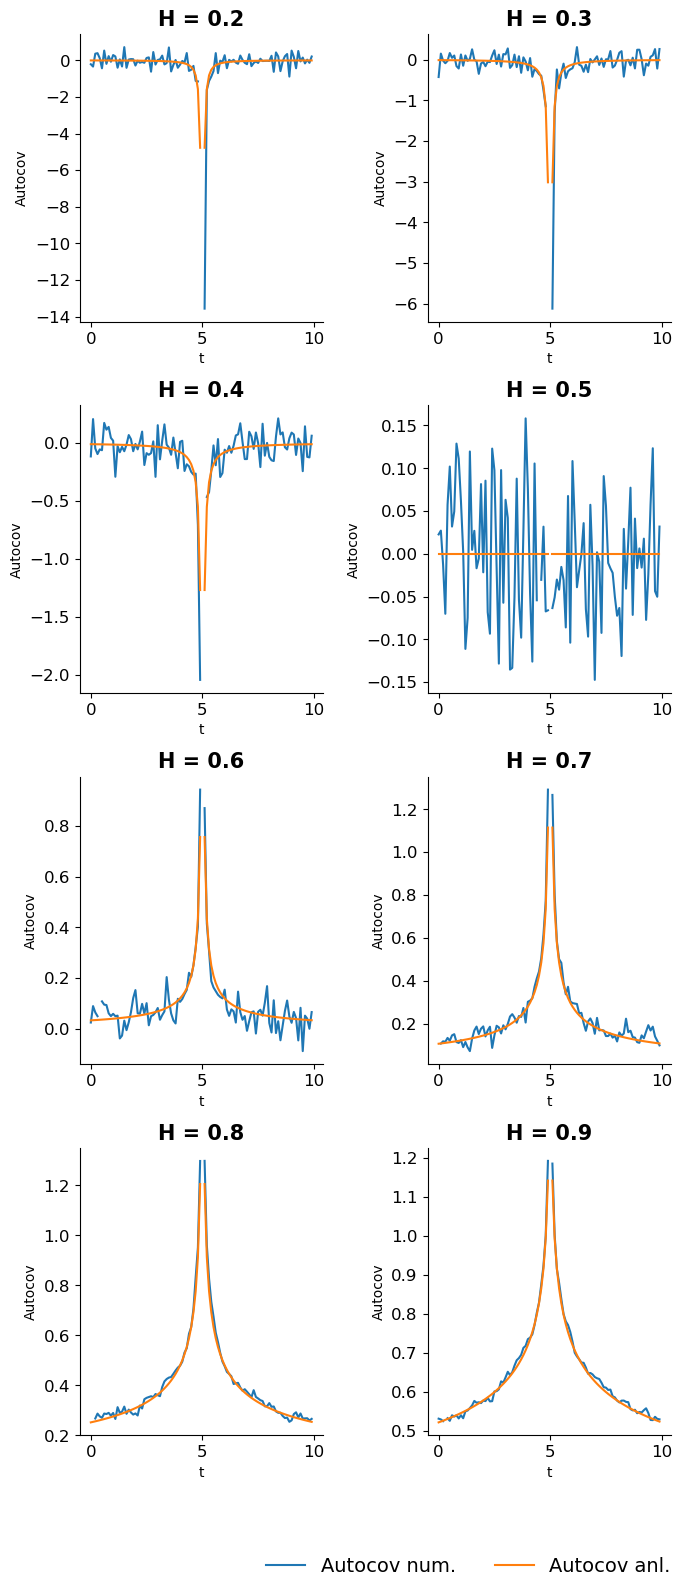

In [18]:
t_ref = 5
fig, ax = plt.subplots(4, 2, figsize=(7,15))


H = 0.2
plot_cov_noise(ax[0][0], H, t_ref)

H = 0.3
plot_cov_noise(ax[0][1], H, t_ref)

H = 0.4
plot_cov_noise(ax[1][0], H, t_ref)

H = 0.5
plot_cov_noise(ax[1][1], H, t_ref)

H = 0.6
plot_cov_noise(ax[2][0], H, t_ref)

H = 0.7
plot_cov_noise(ax[2][1], H, t_ref)

H = 0.8
plot_cov_noise(ax[3][0], H, t_ref)

H = 0.9
plot_cov_noise(ax[3][1], H, t_ref)

fig.tight_layout()
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (0.99, -0.03), ncol = len(h_s)/2);